# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [298]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# imblearn modules
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [255]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
# Select relevant columns given by [1]
fm_df = d[['fico', 'mi_pct', 'cnt_units', 'dti', 'orig_upb', 'int_rt', 'cnt_borr', 'flag_fthb', 'occpy_sts', 'prop_type', 'loan_status']]
# Filter for only prepaid or defaulted mortgages
fm_df = fm_df[fm_df['loan_status'].isin(['prepaid', 'default'])]

C:\Users\User\AppData\Local\Temp\ipykernel_28120\91122356.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


In [256]:
# Check for missing values
fico_count = fm_df[fm_df['fico'] == 9999].shape[0]
mi_pct_count = fm_df[fm_df['mi_pct'] == 999].shape[0]
cnt_units_count = fm_df[fm_df['cnt_units'] == 99].shape[0]
dti_count = fm_df[fm_df['dti'] == 999].shape[0]
flag_fthb_count = fm_df[fm_df['flag_fthb'] == '9'].shape[0]
occpy_sts_count = fm_df[fm_df['occpy_sts'] == '9'].shape[0]
prop_type_count = fm_df[fm_df['prop_type'] == '99'].shape[0]
# Print number of missing values
print(fico_count, mi_pct_count, cnt_units_count, dti_count, flag_fthb_count, occpy_sts_count, prop_type_count)

24 1 0 1304 0 0 0


In [257]:
fm_df['fico'] = fm_df['fico'].replace(9999, np.nan)
fm_df['mi_pct'] = fm_df['mi_pct'].replace(999, np.nan)
fm_df['dti'] = fm_df['dti'].replace(999, np.nan)

In [199]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126705 entries, 0 to 199986
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fico         126681 non-null  float64
 1   mi_pct       126704 non-null  float64
 2   cnt_units    126705 non-null  object 
 3   dti          125401 non-null  float64
 4   orig_upb     126705 non-null  int64  
 5   int_rt       126705 non-null  float64
 6   cnt_borr     126705 non-null  object 
 7   flag_fthb    126705 non-null  object 
 8   occpy_sts    126705 non-null  object 
 9   prop_type    126705 non-null  object 
 10  loan_status  126705 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 11.6+ MB


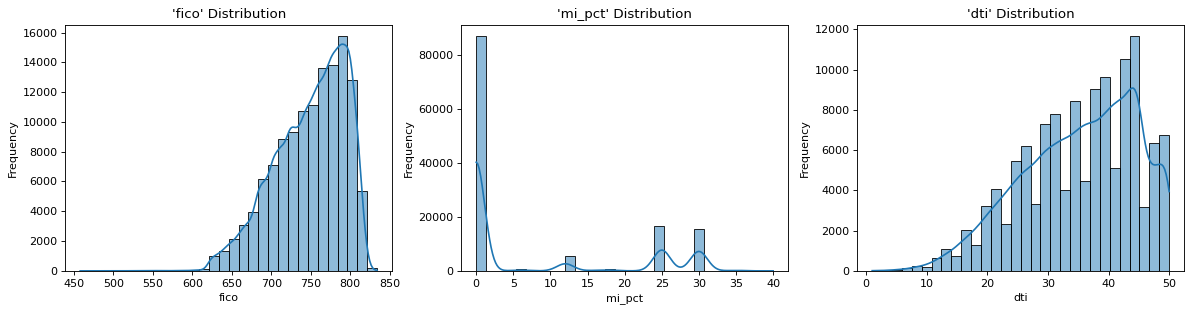

In [258]:
# Select numeric columns
numeric_missing = ['fico', 'mi_pct', 'dti']
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns
for i, col in enumerate(numeric_missing):
    sns.histplot(fm_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"'{col}' Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [259]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = fm_df.select_dtypes(include='object').columns

for col in categorical_cols:
    # Group and normalize proportions
    group_counts = fm_df.groupby(['has_missing', col]).size().reset_index(name='count')
    group_totals = group_counts.groupby('has_missing')['count'].transform('sum')
    group_counts['proportion'] = group_counts['count'] / group_totals

    # Plot normalized proportions
    plt.figure(figsize=(8, 4))
    sns.barplot(data=group_counts, x=col, y='proportion', hue='has_missing')
    plt.title(f"Normalized Distribution of '{col}' (Missing vs Non-Missing Rows)")
    plt.ylabel('Proportion within has_missing')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


KeyError: 'has_missing'

In [260]:
# Feature matrix and response vector
X, y = fm_df.drop(['loan_status'], axis=1), fm_df['loan_status']
# Encode target
y = LabelEncoder().fit_transform(y)
# Split test and train with similar proportion of default and prepaid
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, test_size=0.2, random_state=0
)

In [261]:
# Change variable types 
fm_df['cnt_units'] = fm_df['cnt_units'].astype('object')
fm_df['cnt_borr'] = fm_df['cnt_borr'].astype('object')
# Create a list of categorical columns
categorical = fm_df.select_dtypes(include=['object']).drop(columns=['loan_status']).columns.tolist()
# Create a list of numerical columns
numerical = fm_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Create lists for impution type
median_impute = ['fico', 'dti']
mode_impute = ['mi_pct']
# Numerical imputer pipeline
num_imputer = Pipeline([
    ('impute', ColumnTransformer([
    ("mode_impute", SimpleImputer(strategy='mean'), mode_impute),
    ("median_impute", SimpleImputer(strategy='median'), median_impute)
], remainder='passthrough'))])
# Categorical onehotencoder pipeline
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
])
# Nest pipelines then standardise
pre_processing = Pipeline([
    ("column_transform", ColumnTransformer([
        ("num_impute", num_imputer, numerical),
        ("cat_pre", cat_pipeline, categorical)
    ])),
    ("scaler", StandardScaler())
])

In [262]:
# Final pipeline
baseline_pipeline = Pipeline([
    ("pre_processing", pre_processing),
    ("classifier", LogisticRegression(random_state=0, penalty=None))
])
# Fit the pipeline to the training data
baseline_pipeline = baseline_pipeline.fit(X_train, y_train)

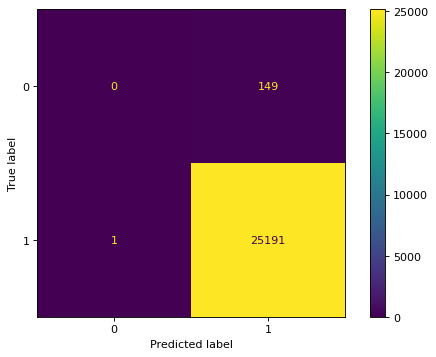

In [221]:
ConfusionMatrixDisplay.from_estimator(baseline_pipeline, X_test, y_test)
plt.show()

In [263]:
from sklearn.metrics import classification_report

print(classification_report(y_test, 
                            baseline_pipeline.predict(X_test), 
                            target_names = ['Default','Prepaid']))

              precision    recall  f1-score   support

     Default       0.00      0.00      0.00       149
     Prepaid       0.99      1.00      1.00     25192

    accuracy                           0.99     25341
   macro avg       0.50      0.50      0.50     25341
weighted avg       0.99      0.99      0.99     25341



In [316]:
log_us_pipeline = ImPipeline([
    ("column_transform", ColumnTransformer([
        ("num_impute", num_imputer, numerical),
        ("cat_pre", cat_pipeline, categorical)
    ])),
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=0)),
    ("classifier", LogisticRegression(random_state=0, penalty='l2', solver='liblinear'))
])

log_us_pipeline = log_us_pipeline.fit(X_train, y_train)


In [ ]:
from sklearn.model_selection import GridSearchCV
l1_ratios = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__l1_ratio': l1_ratios
}

grid_search = GridSearchCV(
    log_us_pipeline,
    param_grid=param_grid,
    scoring='f1',  # or 'recall', 'accuracy', etc. — depends on your priority
    cv=5,
    refit=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

              precision    recall  f1-score   support

     Default       0.01      0.67      0.02       149
  No Default       1.00      0.68      0.81     25192

    accuracy                           0.68     25341
   macro avg       0.50      0.68      0.42     25341
weighted avg       0.99      0.68      0.81     25341



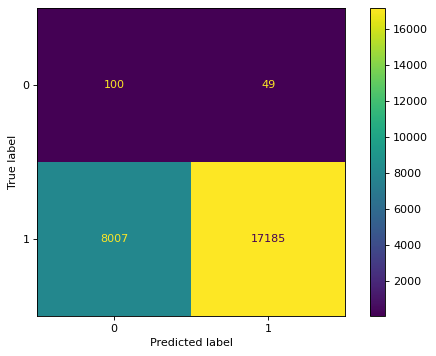

In [315]:
# Print the classification report
print(classification_report(y_test, 
                            log_us_pipeline.predict(X_test), 
                            target_names = ['Default','No Default']))

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_us_pipeline, X_test, y_test)
plt.show()

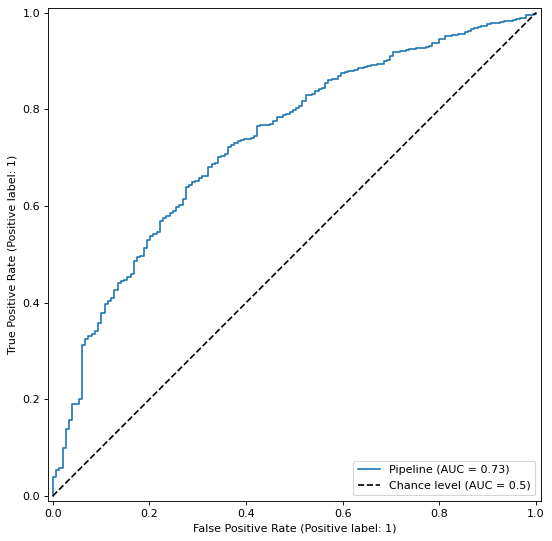

AUC: 0.7321297269187406


In [305]:
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(log_us_pipeline, X_test, y_test,plot_chance_level=True, ax = ax)
plt.show()

# Compute the probabilities for each class on the test data (N_test by C matrix)
y_test_prob = log_us_pipeline.predict_proba(X_test)

# Compute the AUC
print('AUC:', roc_auc_score(y_test, y_test_prob[:,1]))

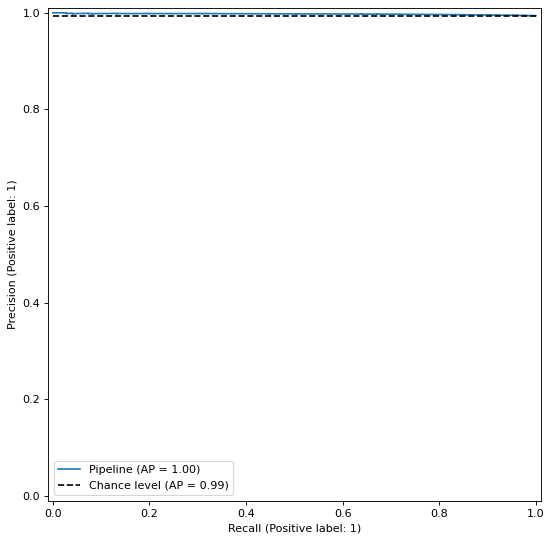

In [279]:
fig, ax = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_estimator(log_us_pipeline, X_test, y_test,plot_chance_level=True, ax = ax)
plt.show()

In [268]:
# Consider 5 folds
KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    # Initialize an empty DataFrame to store counts for the current fold type
    fold_nos = pd.DataFrame()
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        # Compute value counts for the current fold and ensure it's a DataFrame with appropriate columns
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts()).T
        fold_no.index = ["Fold " + str(j)]  # Rename the index to reflect the fold number
        # Concatenate with the fold_nos DataFrame
        fold_nos = pd.concat([fold_nos, fold_no], axis=0)
    
    fold_nos.fillna(0, inplace=True)  # Fill missing values with 0 if any class was not present in a fold
    print(f"{fold_names[i]} counts per fold:\n", fold_nos)

KFold counts per fold:
             1    0
Fold 0  20153  120
Fold 1  20154  119
Fold 2  20135  138
Fold 3  20164  109
Fold 4  20161  111
StratifiedKFold counts per fold:
             1    0
Fold 0  20154  119
Fold 1  20154  119
Fold 2  20153  120
Fold 3  20153  120
Fold 4  20153  119


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb